# Predicting Travel Mode and Trip Purpose Choices
In this notebook, I am using survey data covering thousands of trips in San Francisco Bay Area to predict travel mode and trip purpose. The utilized dataset includes anonymized personal information, such as income and gender, in addition to level-of-service attributes of different travel modes, such as travel time and cost. These types of models predicting people's travel choices help understanding their travel behavior and activities. They enable trasnportation planners to test and analyze different policies and strategies, such as adding new infrastructure and applying new demand management policies.    
After importing the required packages in this section, I implemented some functions in *Section 2* to read the full dataset and preprocess the data, e.g., drop missing values. *Section 3* contains two functions to implement two baseline models (decision trees and random forest) and a deep nueral network. *Sections 4 and 5* presents two models for predicting travel mode, while *Sections 6 and 7* presents models for trip purposes. The hyperparameters of all models were adjusted using Keras Tuners. *Section 8* concludes the findings and *Section 9* lists some proposals for future work. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
import tensorflow as tf
import keras

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import np_utils

import keras_tuner as kt

# Data Retrieval and Preprocessing
* Reading the whole dataset and defining the relevant parameters to consider during building the different models
* Creating methods to prepare the data
    * Adding labels
    * Dropping missing values
    * Combining infrequent samples

In [ ]:
data_full = pd.read_csv('./Data/time_cost_calculated (1).csv', low_memory=False)

Column names of x and y variables

In [5]:
vars_mode_freq = ['car', 'taxi', 'bus', 'train', 'para']
vars_ind = ['r_age', 'drvr', 'r_sex', 'r_hisp', 'r_relat', 'r_race', 'wrk_home', 'wkftpt', 'homeown', 'educ']
vars_hh = ['hhsize', 'hhfaminc']
vars_trip = ['o_taz', 'd_taz', 'trpmiles']
vars_time_skims = ['da_timeSkims', 'wTrnW_timeSkims', 'dTrnW_timeSkims', 'wTrnD_timeSkims'] #'daToll_timeSkims', 's2_timeSkims', 's2Toll_timeSkims', 's3_timeSkims', 's3Toll_timeSkims', 
vars_cost_skims = ['da_costSkims', 'wTrnW_costSkims', 'dTrnW_costSkims', 'wTrnD_costSkims'] #'daToll_costSkims', 's2_costSkims', 's2Toll_costSkims', 's3_costSkims', 's3Toll_costSkims', 
vars_active_modes = ['travelTimeWalk', 'travelTimeBike']

## Data Labels
Reading the labels (meaning) of the values of all categorical variables.

In [6]:
def read_labels(var_values, columns_x, columns_y):
    x_vars = {}
    for var in columns_x:
        x_vars[var] = var_values[var_values.NAME==var][['VALUE','LABEL']]
        x_vars[var]['VALUE'] = pd.to_numeric(x_vars[var].VALUE, downcast='integer')
        x_vars[var].set_index('VALUE', inplace=True)
        x_vars[var] = x_vars[var].to_dict()['LABEL']
    y_vars = {}
    for var in columns_y:
        y_vars[var] = var_values[var_values.NAME==var][['VALUE','LABEL']]
        y_vars[var]['VALUE'] = pd.to_numeric(y_vars[var].VALUE, downcast='integer')
        y_vars[var].set_index('VALUE', inplace=True)
        y_vars[var] = y_vars[var].to_dict()['LABEL']
    return x_vars, y_vars

## Missing Values
Removing missing values out of the dataset. Negative values are usually used to represent non-specific ansewrs for the survey questions.

In [7]:
def remove_missing_values(data_full, columns_x, columns_y, remove_missing_taz=True, remove_missing_x=True, remove_missing_y=True):
    # Dropping undefined origins and destinations
    if remove_missing_taz:
        data = data_full.dropna(subset=['o_taz', 'd_taz'])
        data = data[columns_x+columns_y]
    # Remove rows with missing values for independent variables
    if remove_missing_x:
        for var in columns_x:
            data = data[(data[var]>0) & (data[var]!=97)]
    # Remove rows with missing values for dependent variables
    if remove_missing_y:
        for var in columns_y:
            data = data[(data[var]>0) & (data[var]!=97)]
    return data

## Adding Labels & Combining Rare Outputs
* Adding columns of labels based on the values of specific columns
* For categorical variables, combine all values that do not appear frequently in the dataset.

In [8]:
def add_labels(data, var_values, columns, suffix="_label"):
    for var in columns:
        var_labels = var_values[var_values.NAME==var][['VALUE','LABEL']]
        var_labels['VALUE'] = pd.to_numeric(var_labels.VALUE, downcast='integer')
        var_labels.set_index('VALUE', inplace=True)
        var_labels = var_labels.to_dict()['LABEL']
        data[var+suffix] = data[var].apply(lambda x:var_labels[x])
    return data
        
def combine_values(data, columns, thresholds, suffix="_combined"):
    for var, threshold in zip(columns, thresholds):
        hist_vals = data[var].value_counts()
        aggregated_values = list(hist_vals[hist_vals<threshold].index)
        other_value_label = 'Other'
        remaining_values = list(hist_vals[hist_vals>=threshold].index) + [other_value_label]
        data[var+suffix] = data[var].apply(lambda x:other_value_label if x in aggregated_values else x)
    return data

# Models

## Baselines
A method to build decision trees and random forest models, which can be used as baselines to evaluate teh quality of the dep learning models

In [9]:
def build_baseline(model, x_train, y_train, x_test, y_test, report_results=True):
    # estimating the model
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    # reporting the results
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, predictions))
    return predictions

## Deep Learning

In [10]:
def build_model(hp):
    global input_dim, output_dim
    model = models.Sequential()
    model.add(layers.Dense(hp.Int('dense1', min_value=32, max_value=256, step=32), 
                           input_dim=input_dim , activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(layers.Dense(hp.Int('dense2', min_value=32, max_value=256, step=32), 
                           activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(layers.Dense(output_dim, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss='categorical_crossentropy' , metrics=['accuracy'] )
    
    return model

# Scenario 1
Using all relevant variables to predict travel mode

In [11]:
# x & y columns
columns_y = ['trptrans17']
columns_x = vars_mode_freq + vars_ind + vars_hh + vars_trip + vars_time_skims + vars_cost_skims + vars_active_modes
# Thresholds for combining rare vales
thresholds_y = [150]

Checking values of included variables and their labels

In [12]:
var_values = pd.read_excel('./Data/data_elements110718.xlsx', sheet_name='Value Lookup')
var_values.NAME = var_values.NAME.str.lower()
# Read labels
x_vars, y_vars = read_labels(var_values, columns_x, columns_y)
for var in columns_x:
    print("===={}====".format(var))
    print(x_vars[var])
for var in columns_y:
    print("===={}====".format(var))
    print(y_vars[var])

====car====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily ', 2: 'A few times a week', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never'}
====taxi====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily ', 2: 'A few times a week ', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never '}
====bus====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily', 2: 'A few times a week ', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never'}
====train====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily ', 2: 'A few times a week', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never '}
====para====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily ', 2: 'A few times a week', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never '}
====r_age====
{-9: 'Not ascertained',

## Data Preparation

Car                                            4351
Walk                                            679
SUV                                             661
Subway / elevated / light rail / street car     293
Pickup truck                                    253
Van                                             211
Public or commuter bus                          178
Bicycle                                         170
Amtrak / Commuter rail                           82
Private / Charter / Tour / Shuttle bus           35
City-to-city bus (Greyhound, Megabus)             2
Paratransit / Dial-a-ride                         1
Name: trptrans17_label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6916 entries, 13 to 28613
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   car                        6916 non-null   int64  
 1   taxi                       6916 non-null   int64  
 2   b

,car,taxi,bus,train,para,r_age,drvr,r_sex,r_hisp,r_relat,...,wTrnW_timeSkims,dTrnW_timeSkims,wTrnD_timeSkims,da_costSkims,wTrnW_costSkims,dTrnW_costSkims,wTrnD_costSkims,travelTimeWalk,travelTimeBike,trptrans17
count,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,...,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000
mean,1.431319,3.983227,4.102805,3.638519,4.959080,45.582707,1.041064,1.482504,1.933632,1.580249,...,51.058606,39.471128,39.593062,158.103401,232.146327,211.150665,216.480769,124.135867,38.653084,3.999422
std,0.854436,0.911250,1.179477,1.236718,0.265494,13.538866,0.198453,0.499730,0.248942,1.017594,...,27.659015,23.173375,23.343844,206.015266,155.519285,121.124362,126.577737,153.561571,47.815579,3.321744
min,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000,1.000000,1.000000,1.000000,...,7.710000,4.790000,4.660000,10.180000,1.000000,1.000000,1.000000,1.346154,0.419162,1.000000
25%,1.000000,3.000000,4.000000,3.000000,5.000000,34.000000,1.000000,1.000000,2.000000,1.000000,...,30.340000,22.887500,23.015000,42.190000,161.000000,161.000000,161.000000,28.461538,8.862275,3.000000
50%,1.000000,4.000000,5.000000,4.000000,5.000000,45.000000,1.000000,1.000000,2.000000,1.000000,...,44.785000,34.240000,34.275000,74.840000,161.000000,161.000000,161.000000,61.346154,19.101796,3.000000
75%,2.000000,5.000000,5.000000,5.000000,5.000000,56.000000,1.000000,2.000000,2.000000,2.000000,...,65.750000,50.880000,50.972500,181.260000,276.250000,181.000000,220.000000,158.461538,49.341317,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,92.000000,2.000000,2.000000,2.000000,7.000000,...,196.780000,185.390000,184.910000,1663.050000,1285.000000,1285.000000,1124.000000,1263.461538,393.413174,16.000000


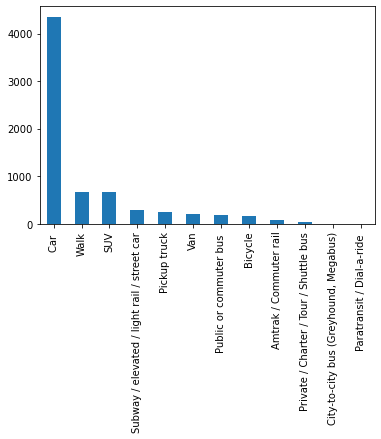

In [13]:
# Removing missing values
data = remove_missing_values(data_full, columns_x, columns_y)
# Adding mode labels
add_labels(data, var_values, columns_y)
columns_y = list(map(lambda x:x+"_label", columns_y))
# Displaying histogram of modes
print(data[columns_y[0]].value_counts())
data[columns_y[0]].value_counts().plot(kind='bar')
# Combining rare modes
combine_values(data, columns_y, thresholds_y, suffix="_combined")
columns_y = list(map(lambda x:x+"_combined", columns_y))

data.info()
data.describe()

## Baselines

In [14]:
data = shuffle(data)
x_samples = data[columns_x]
y_samples = data[columns_y[0]]
x_samples.shape, y_samples.shape
x_train, x_test, y_train, y_test = train_test_split(x_samples, y_samples, test_size=0.2)

### Decision Trees

In [15]:
dtree = DecisionTreeClassifier()
predictions = build_baseline(dtree, x_train, y_train, x_test, y_test)

Classification Report
                                             precision    recall  f1-score   support

                                    Bicycle       0.33      0.34      0.34        32
                                       Car        0.84      0.83      0.83       888
                                      Other       0.44      0.43      0.44        28
                               Pickup truck       0.53      0.57      0.55        56
                    Public or commuter bus        0.46      0.44      0.45        27
                                        SUV       0.45      0.52      0.48       115
Subway / elevated / light rail / street car       0.43      0.48      0.46        58
                                        Van       0.56      0.54      0.55        50
                                       Walk       0.73      0.66      0.69       130

                                   accuracy                           0.72      1384
                                  macro a

### Random Forest

In [16]:
rfc = RandomForestClassifier(n_estimators=100)
predictions = build_baseline(rfc, x_train, y_train, x_test, y_test)

Classification Report
                                             precision    recall  f1-score   support

                                    Bicycle       0.69      0.28      0.40        32
                                       Car        0.80      0.97      0.87       888
                                      Other       1.00      0.36      0.53        28
                               Pickup truck       0.94      0.29      0.44        56
                    Public or commuter bus        0.72      0.67      0.69        27
                                        SUV       0.93      0.34      0.50       115
Subway / elevated / light rail / street car       0.78      0.60      0.68        58
                                        Van       1.00      0.32      0.48        50
                                       Walk       0.83      0.85      0.84       130

                                   accuracy                           0.81      1384
                                  macro a

## Deep Learning
Converting modes into one-hot encoded strings

In [17]:
X = data[columns_x]
y = data[columns_y[0]]
print(y)
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
y = np_utils.to_categorical(y)
print(y)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size = 0.1, random_state = 0)

4791              SUV
22994            Car 
6611              SUV
11109            Car 
11414    Pickup truck
             ...     
1497             Car 
24954            Car 
5866             Car 
17449         Bicycle
2948             Car 
Name: trptrans17_label_combined, Length: 6916, dtype: object
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [18]:
input_dim = len(columns_x)
output_dim = len(y[0])

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='scenario1',
                     project_name='travel_mode',
                     overwrite=True)

stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner.search(x_train, y_train, epochs=50, callbacks=[stop_early],
            validation_data=(x_val, y_val))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The optimal number of units in the first dense layer is {best_hps.get('dense1')},\n"
      f" the optimal rate in the first dropout layer is {best_hps.get('dropout1')},\n"
      f" the optimal number of units in the second dense layer is {best_hps.get('dense2')},\n"
      f" the optimal rate in the second dropout layer is {best_hps.get('dropout2')},\n"
      f" and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.6260032057762146

Best val_accuracy So Far: 0.6532905101776123
Total elapsed time: 00h 02m 05s
INFO:tensorflow:Oracle triggered exit
The optimal number of units in the first dense layer is 224,
 the optimal rate in the first dropout layer is 0.05,
 the optimal number of units in the second dense layer is 128,
 the optimal rate in the second dropout layer is 0.05,
 and the optimal learning rate for the optimizer is 0.01.


In [19]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

22/22 [==============================] - 0s 751us/step - loss: 1.1054 - accuracy: 0.6792


# Scenario 2
Using travel mode LOS attributes only to predict travel mode

In [20]:
# x & y columns
columns_y = ['trptrans17'] #'whyto'
columns_x = vars_time_skims + vars_cost_skims + vars_active_modes
# Thresholds for combining rare vales
thresholds_y = [150]

Checking values of included variables and their labels

In [21]:
var_values = pd.read_excel('./Data/data_elements110718.xlsx', sheet_name='Value Lookup')
var_values.NAME = var_values.NAME.str.lower()
# Read labels
x_vars, y_vars = read_labels(var_values, columns_x, columns_y)
for var in columns_x:
    print("===={}====".format(var))
    print(x_vars[var])
for var in columns_y:
    print("===={}====".format(var))
    print(y_vars[var])

====da_timeSkims====
{}
====wTrnW_timeSkims====
{}
====dTrnW_timeSkims====
{}
====wTrnD_timeSkims====
{}
====da_costSkims====
{}
====wTrnW_costSkims====
{}
====dTrnW_costSkims====
{}
====wTrnD_costSkims====
{}
====travelTimeWalk====
{}
====travelTimeBike====
{}
====trptrans17====
{-8: "I don't know", -7: 'I prefer not to answer', 1: 'Walk', 2: 'Bicycle', 3: 'Car ', 4: 'SUV', 5: 'Van', 6: 'Pickup truck', 7: 'Golf cart / Segway ', 8: 'Motorcycle / Moped', 9: 'RV (motor home, ATV, snowmobile)', 10: 'School bus', 11: 'Public or commuter bus ', 12: 'Paratransit / Dial-a-ride ', 13: 'Private / Charter / Tour / Shuttle bus', 14: 'City-to-city bus (Greyhound, Megabus)', 15: 'Amtrak / Commuter rail', 16: 'Subway / elevated / light rail / street car', 17: 'Taxi / limo (including Uber / Lyft)', 18: 'Rental car (Including Zipcar / Car2Go)', 19: 'Airplane ', 20: 'Boat / ferry / water taxi ', 97: 'Something Else '}


## Data Preparation

Car                                            8872
SUV                                            1555
Walk                                           1374
Van                                             542
Pickup truck                                    491
Public or commuter bus                          417
Subway / elevated / light rail / street car     380
Bicycle                                         333
Amtrak / Commuter rail                          133
Private / Charter / Tour / Shuttle bus           51
School bus                                       19
City-to-city bus (Greyhound, Megabus)             3
Paratransit / Dial-a-ride                         3
Rental car (Including Zipcar / Car2Go)            1
Name: trptrans17_label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14174 entries, 13 to 28613
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   da_timeS

,da_timeSkims,wTrnW_timeSkims,dTrnW_timeSkims,wTrnD_timeSkims,da_costSkims,wTrnW_costSkims,dTrnW_costSkims,wTrnD_costSkims,travelTimeWalk,travelTimeBike,trptrans17
count,14174.000000,14174.000000,14174.000000,14174.000000,14174.000000,14174.000000,14174.000000,14174.000000,14174.000000,14174.000000,14174.000000
mean,12.998509,50.177960,38.577152,38.698437,140.907577,222.053055,204.264710,209.560392,111.694964,34.779270,3.819881
std,10.729804,26.947878,22.274656,22.522110,192.238678,144.772978,114.481024,119.985673,145.488550,45.301824,2.926282
min,3.110000,7.710000,4.790000,4.660000,10.180000,1.000000,1.000000,1.000000,1.346154,0.419162,1.000000
25%,6.770000,30.370000,22.850000,22.922500,40.490000,161.000000,161.000000,161.000000,26.538462,8.263473,3.000000
50%,9.240000,43.955000,33.465000,33.460000,67.630000,161.000000,161.000000,161.000000,54.807692,17.065868,3.000000
75%,14.757500,63.910000,49.370000,49.515000,147.340000,181.000000,181.000000,181.000000,132.115385,41.137725,4.000000
max,111.310000,196.780000,185.390000,184.910000,1686.300000,1285.000000,1285.000000,1124.000000,1263.461538,393.413174,18.000000


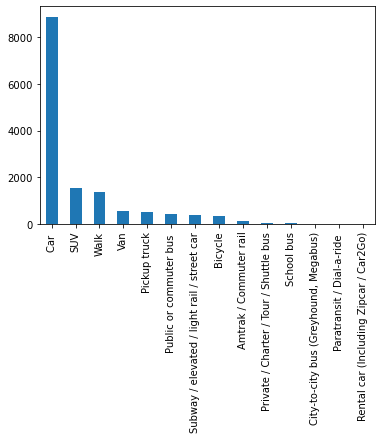

In [22]:
# Removing missing values
data = remove_missing_values(data_full, columns_x, columns_y)
# Adding mode labels
add_labels(data, var_values, columns_y)
columns_y = list(map(lambda x:x+"_label", columns_y))
# Displaying histogram of modes
print(data[columns_y[0]].value_counts())
data[columns_y[0]].value_counts().plot(kind='bar')
# Combining rare modes
combine_values(data, columns_y, thresholds_y, suffix="_combined")
columns_y = list(map(lambda x:x+"_combined", columns_y))

data.info()
data.describe()

## Baselines

In [23]:
data = shuffle(data)
x_samples = data[columns_x]
y_samples = data[columns_y[0]]
x_samples.shape, y_samples.shape
x_train, x_test, y_train, y_test = train_test_split(x_samples, y_samples, test_size=0.2)

### Decision Trees

In [25]:
dtree = DecisionTreeClassifier()
predictions = build_baseline(dtree, x_train, y_train, x_test, y_test)

Classification Report
                                             precision    recall  f1-score   support

                                    Bicycle       0.23      0.25      0.24        56
                                       Car        0.79      0.78      0.78      1771
                                      Other       0.23      0.32      0.27        38
                               Pickup truck       0.30      0.33      0.31        92
                    Public or commuter bus        0.20      0.19      0.19        89
                                        SUV       0.48      0.47      0.47       318
Subway / elevated / light rail / street car       0.27      0.25      0.26        67
                                        Van       0.50      0.53      0.52       122
                                       Walk       0.68      0.68      0.68       282

                                   accuracy                           0.66      2835
                                  macro a

### Random Forest

In [26]:
rfc = RandomForestClassifier(n_estimators=100)
predictions = build_baseline(rfc, x_train, y_train, x_test, y_test)

Classification Report
                                             precision    recall  f1-score   support

                                    Bicycle       0.50      0.14      0.22        56
                                       Car        0.75      0.94      0.84      1771
                                      Other       0.60      0.16      0.25        38
                               Pickup truck       0.72      0.30      0.43        92
                    Public or commuter bus        0.52      0.16      0.24        89
                                        SUV       0.79      0.42      0.54       318
Subway / elevated / light rail / street car       0.43      0.24      0.31        67
                                        Van       0.82      0.50      0.62       122
                                       Walk       0.77      0.74      0.75       282

                                   accuracy                           0.75      2835
                                  macro a

## Deep Learning Models

In [27]:
X = data[columns_x]
y = data[columns_y[0]]
print(y)
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
y = np_utils.to_categorical(y)
print(y)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size = 0.1, random_state = 0)

9607                        Car 
11725                       Car 
19275                       Car 
18936                       Car 
22410                       Car 
                  ...           
23475                       Car 
581                         Car 
3361                        Car 
2879     Public or commuter bus 
7542                         SUV
Name: trptrans17_label_combined, Length: 14174, dtype: object
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [28]:
input_dim = len(columns_x)
output_dim = len(y[0])

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='scenario2',
                     project_name='travel_mode',
                     overwrite=True)

stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner.search(x_train, y_train, epochs=50, callbacks=[stop_early],
            validation_data=(x_val, y_val))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The optimal number of units in the first dense layer is {best_hps.get('dense1')},\n"
      f" the optimal rate in the first dropout layer is {best_hps.get('dropout1')},\n"
      f" the optimal number of units in the second dense layer is {best_hps.get('dense2')},\n"
      f" the optimal rate in the second dropout layer is {best_hps.get('dropout2')},\n"
      f" and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

Trial 30 Complete [00h 00m 08s]
val_accuracy: 0.6316614151000977

Best val_accuracy So Far: 0.6661441922187805
Total elapsed time: 00h 02m 36s
INFO:tensorflow:Oracle triggered exit
The optimal number of units in the first dense layer is 224,
 the optimal rate in the first dropout layer is 0.0,
 the optimal number of units in the second dense layer is 160,
 the optimal rate in the second dropout layer is 0.15000000000000002,
 and the optimal learning rate for the optimizer is 0.001.


In [29]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

45/45 [==============================] - 0s 760us/step - loss: 1.1751 - accuracy: 0.6622


# Scenario 3
Using all relevant variables to predict trip purpose

In [30]:
# x & y columns
columns_y = ['whyto']
columns_x = vars_mode_freq + vars_ind + vars_hh + vars_trip + vars_time_skims + vars_cost_skims + vars_active_modes
# Thresholds for combining rare vales
thresholds_y = [50]

Checking values of included variables and their labels

In [31]:
var_values = pd.read_excel('./Data/data_elements110718.xlsx', sheet_name='Value Lookup')
var_values.NAME = var_values.NAME.str.lower()
# Read labels
x_vars, y_vars = read_labels(var_values, columns_x, columns_y)
for var in columns_x:
    print("===={}====".format(var))
    print(x_vars[var])
for var in columns_y:
    print("===={}====".format(var))
    print(y_vars[var])

====car====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily ', 2: 'A few times a week', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never'}
====taxi====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily ', 2: 'A few times a week ', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never '}
====bus====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily', 2: 'A few times a week ', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never'}
====train====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily ', 2: 'A few times a week', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never '}
====para====
{-8: "I don't know ", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: 'Daily ', 2: 'A few times a week', 3: 'A few times a month ', 4: 'A few times a year ', 5: 'Never '}
====r_age====
{-9: 'Not ascertained',

## Data Preparation

1. Regular home activities (chores, sleep)                           2168
3. Work                                                              1276
11. Buy goods (groceries, clothes, appliances, gas)                   838
13. Buy meals (go out for a meal, snack, carry-out)                   563
6. Drop off /pick up someone                                          525
16. Exercise (go for a jog, walk, walk the dog, go to the gym)        274
17. Visit friends or relatives                                        221
15. Recreational activities (visit parks, movies, bars, museums)      209
14. Other general errands (post office, library)                      142
4. Work-related meeting / trip                                        129
12. Buy services (dry cleaners, banking, service a car, pet care)     129
7. Change type of transportation                                      104
2. Work from home (paid)                                              101
18. Health care visit (medical, dental

,car,taxi,bus,train,para,r_age,drvr,r_sex,r_hisp,r_relat,...,wTrnW_timeSkims,dTrnW_timeSkims,wTrnD_timeSkims,da_costSkims,wTrnW_costSkims,dTrnW_costSkims,wTrnD_costSkims,travelTimeWalk,travelTimeBike,whyto
count,6908.000000,6908.000000,6908.000000,6908.00000,6908.000000,6908.000000,6908.000000,6908.000000,6908.000000,6908.000000,...,6908.000000,6908.000000,6908.000000,6908.000000,6908.000000,6908.000000,6908.000000,6908.000000,6908.000000,6908.000000
mean,1.431673,3.982774,4.102635,3.63839,4.959178,45.569774,1.041112,1.482629,1.933555,1.580486,...,51.059644,39.472099,39.590427,158.067038,232.026346,211.080921,216.384047,124.074540,38.633989,6.548350
std,0.854793,0.911531,1.179934,1.23699,0.265394,13.536129,0.198563,0.499734,0.249076,1.018026,...,27.646393,23.167378,23.325610,205.905100,155.316626,121.074752,126.422411,153.370545,47.756098,5.675747
min,1.000000,1.000000,1.000000,1.00000,1.000000,16.000000,1.000000,1.000000,1.000000,1.000000,...,7.710000,4.790000,4.660000,10.180000,1.000000,1.000000,1.000000,1.346154,0.419162,1.000000
25%,1.000000,3.000000,4.000000,3.00000,5.000000,34.000000,1.000000,1.000000,2.000000,1.000000,...,30.347500,22.887500,23.020000,42.190000,161.000000,161.000000,161.000000,28.461538,8.862275,1.000000
50%,1.000000,4.000000,5.000000,4.00000,5.000000,45.000000,1.000000,1.000000,2.000000,1.000000,...,44.830000,34.255000,34.280000,74.840000,161.000000,161.000000,161.000000,61.346154,19.101796,3.000000
75%,2.000000,5.000000,5.000000,5.00000,5.000000,56.000000,1.000000,2.000000,2.000000,2.000000,...,65.750000,50.880000,50.972500,181.260000,273.750000,181.000000,211.750000,158.461538,49.341317,11.000000
max,5.000000,5.000000,5.000000,5.00000,5.000000,92.000000,2.000000,2.000000,2.000000,7.000000,...,196.780000,185.390000,184.910000,1663.050000,1285.000000,1285.000000,1124.000000,1263.461538,393.413174,19.000000


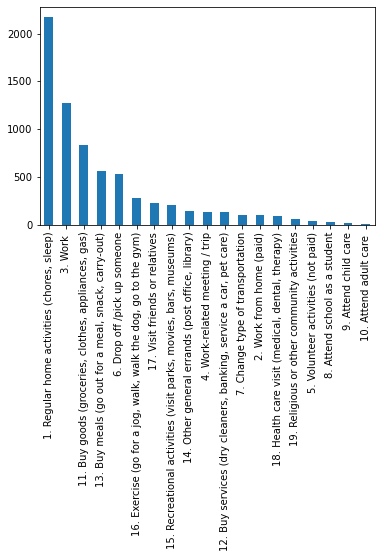

In [32]:
# Removing missing values
data = remove_missing_values(data_full, columns_x, columns_y)
# Adding mode labels
add_labels(data, var_values, columns_y)
columns_y = list(map(lambda x:x+"_label", columns_y))
# Displaying histogram of modes
print(data[columns_y[0]].value_counts())
data[columns_y[0]].value_counts().plot(kind='bar')
# Combining rare  purposes
combine_values(data, columns_y, thresholds_y, suffix="_combined")
columns_y = list(map(lambda x:x+"_combined", columns_y))

data.info()
data.describe()

## Baselines

In [33]:
data = shuffle(data)
x_samples = data[columns_x]
y_samples = data[columns_y[0]]
x_samples.shape, y_samples.shape
x_train, x_test, y_train, y_test = train_test_split(x_samples, y_samples, test_size=0.2)

### Decision Trees

In [34]:
dtree = DecisionTreeClassifier()
predictions = build_baseline(dtree, x_train, y_train, x_test, y_test)

Classification Report
                                                                   precision    recall  f1-score   support

                       1. Regular home activities (chores, sleep)       0.40      0.38      0.39       460
              11. Buy goods (groceries, clothes, appliances, gas)       0.23      0.24      0.24       163
12. Buy services (dry cleaners, banking, service a car, pet care)       0.10      0.09      0.09        33
              13. Buy meals (go out for a meal, snack, carry-out)       0.20      0.17      0.18       112
                 14. Other general errands (post office, library)       0.07      0.13      0.09        23
 15. Recreational activities (visit parks, movies, bars, museums)       0.14      0.14      0.14        36
   16. Exercise (go for a jog, walk, walk the dog, go to the gym)       0.13      0.11      0.12        62
                                   17. Visit friends or relatives       0.15      0.23      0.18        31
              

### Random Forest

In [35]:
rfc = RandomForestClassifier(n_estimators=100)
predictions = build_baseline(rfc, x_train, y_train, x_test, y_test)

Classification Report
                                                                   precision    recall  f1-score   support

                       1. Regular home activities (chores, sleep)       0.36      0.64      0.46       460
              11. Buy goods (groceries, clothes, appliances, gas)       0.33      0.26      0.29       163
12. Buy services (dry cleaners, banking, service a car, pet care)       0.22      0.06      0.10        33
              13. Buy meals (go out for a meal, snack, carry-out)       0.43      0.21      0.28       112
                 14. Other general errands (post office, library)       0.17      0.09      0.11        23
 15. Recreational activities (visit parks, movies, bars, museums)       0.38      0.14      0.20        36
   16. Exercise (go for a jog, walk, walk the dog, go to the gym)       0.27      0.06      0.10        62
                                   17. Visit friends or relatives       0.22      0.13      0.16        31
              

## Deep Learning
Converting modes into one-hot encoded strings

In [36]:
X = data[columns_x]
y = data[columns_y[0]]
print(y)
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
y = np_utils.to_categorical(y)
print(y)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size = 0.1, random_state = 0)

19279    13. Buy meals (go out for a meal, snack, carry...
11457           1. Regular home activities (chores, sleep)
5284            1. Regular home activities (chores, sleep)
26138           1. Regular home activities (chores, sleep)
27108           1. Regular home activities (chores, sleep)
                               ...                        
3859                                              3. Work 
6439            1. Regular home activities (chores, sleep)
444             1. Regular home activities (chores, sleep)
11274                                             3. Work 
3358            1. Regular home activities (chores, sleep)
Name: whyto_label_combined, Length: 6908, dtype: object
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [37]:
input_dim = len(columns_x)
output_dim = len(y[0])

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='scenario3',
                     project_name='trip_purpose',
                     overwrite=True)

stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner.search(x_train, y_train, epochs=50, callbacks=[stop_early],
            validation_data=(x_val, y_val))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The optimal number of units in the first dense layer is {best_hps.get('dense1')},\n"
      f" the optimal rate in the first dropout layer is {best_hps.get('dropout1')},\n"
      f" the optimal number of units in the second dense layer is {best_hps.get('dense2')},\n"
      f" the optimal rate in the second dropout layer is {best_hps.get('dropout2')},\n"
      f" and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

Trial 30 Complete [00h 00m 07s]
val_accuracy: 0.30385851860046387

Best val_accuracy So Far: 0.3070739507675171
Total elapsed time: 00h 01m 58s
INFO:tensorflow:Oracle triggered exit
The optimal number of units in the first dense layer is 128,
 the optimal rate in the first dropout layer is 0.45,
 the optimal number of units in the second dense layer is 224,
 the optimal rate in the second dropout layer is 0.05,
 and the optimal learning rate for the optimizer is 0.01.


In [38]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

22/22 [==============================] - 0s 680us/step - loss: 2.1986 - accuracy: 0.3155


# Scenario 4
Using travel mode LOS attributes only to predict trip purpose

In [39]:
# x & y columns
columns_y = ['whyto']
columns_x = vars_time_skims + vars_cost_skims + vars_active_modes
# Thresholds for combining rare vales
thresholds_y = [50]

Checking values of included variables and their labels

In [40]:
var_values = pd.read_excel('./Data/data_elements110718.xlsx', sheet_name='Value Lookup')
var_values.NAME = var_values.NAME.str.lower()
# Read labels
x_vars, y_vars = read_labels(var_values, columns_x, columns_y)
for var in columns_x:
    print("===={}====".format(var))
    print(x_vars[var])
for var in columns_y:
    print("===={}====".format(var))
    print(y_vars[var])

====da_timeSkims====
{}
====wTrnW_timeSkims====
{}
====dTrnW_timeSkims====
{}
====wTrnD_timeSkims====
{}
====da_costSkims====
{}
====wTrnW_costSkims====
{}
====dTrnW_costSkims====
{}
====wTrnD_costSkims====
{}
====travelTimeWalk====
{}
====travelTimeBike====
{}
====whyto====
{-9: 'Not ascertained', -8: "I don't know", -7: 'I prefer not to answer', -1: 'Appropriate skip', 1: '1. Regular home activities (chores, sleep)', 2: '2. Work from home (paid)', 3: '3. Work ', 4: '4. Work-related meeting / trip', 5: '5. Volunteer activities (not paid)', 6: '6. Drop off /pick up someone', 7: '7. Change type of transportation', 8: '8. Attend school as a student', 9: '9. Attend child care', 10: '10. Attend adult care ', 11: '11. Buy goods (groceries, clothes, appliances, gas)', 12: '12. Buy services (dry cleaners, banking, service a car, pet care)', 13: '13. Buy meals (go out for a meal, snack, carry-out)', 14: '14. Other general errands (post office, library)', 15: '15. Recreational activities (visit

## Data Preparation

1. Regular home activities (chores, sleep)                           4588
11. Buy goods (groceries, clothes, appliances, gas)                  1953
3. Work                                                              1574
13. Buy meals (go out for a meal, snack, carry-out)                  1142
6. Drop off /pick up someone                                         1051
16. Exercise (go for a jog, walk, walk the dog, go to the gym)        646
17. Visit friends or relatives                                        548
15. Recreational activities (visit parks, movies, bars, museums)      504
14. Other general errands (post office, library)                      363
12. Buy services (dry cleaners, banking, service a car, pet care)     324
8. Attend school as a student                                         322
18. Health care visit (medical, dental, therapy)                      282
19. Religious or other community activities                           186
4. Work-related meeting / trip        

,da_timeSkims,wTrnW_timeSkims,dTrnW_timeSkims,wTrnD_timeSkims,da_costSkims,wTrnW_costSkims,dTrnW_costSkims,wTrnD_costSkims,travelTimeWalk,travelTimeBike,whyto
count,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000
mean,12.996249,50.181899,38.581827,38.699883,140.864910,221.989675,204.226575,209.519270,111.689917,34.777699,7.255357
std,10.720015,26.955476,22.282049,22.524289,192.086072,144.620515,114.402341,119.897637,145.427255,45.282738,5.916217
min,3.110000,7.710000,4.790000,4.660000,10.180000,1.000000,1.000000,1.000000,1.346154,0.419162,1.000000
25%,6.770000,30.370000,22.850000,22.920000,40.490000,161.000000,161.000000,161.000000,26.538462,8.263473,1.000000
50%,9.240000,43.960000,33.470000,33.470000,67.630000,161.000000,161.000000,161.000000,55.000000,17.125749,6.000000
75%,14.760000,63.920000,49.380000,49.520000,147.340000,181.000000,181.000000,181.000000,132.115385,41.137725,13.000000
max,111.310000,196.780000,185.390000,184.910000,1686.300000,1285.000000,1285.000000,1124.000000,1263.461538,393.413174,19.000000


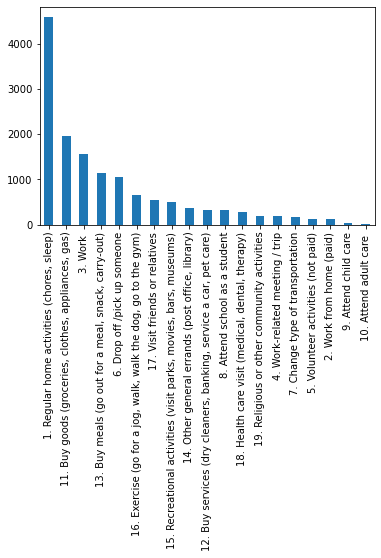

In [41]:
# Removing missing values
data = remove_missing_values(data_full, columns_x, columns_y)
# Adding mode labels
add_labels(data, var_values, columns_y)
columns_y = list(map(lambda x:x+"_label", columns_y))
# Displaying histogram of modes
print(data[columns_y[0]].value_counts())
data[columns_y[0]].value_counts().plot(kind='bar')
# Combining rare purposes
combine_values(data, columns_y, thresholds_y, suffix="_combined")
columns_y = list(map(lambda x:x+"_combined", columns_y))

data.info()
data.describe()

## Baselines

In [42]:
data = shuffle(data)
x_samples = data[columns_x]
y_samples = data[columns_y[0]]
x_samples.shape, y_samples.shape
x_train, x_test, y_train, y_test = train_test_split(x_samples, y_samples, test_size=0.2)

### Decision Trees

In [43]:
dtree = DecisionTreeClassifier()
predictions = build_baseline(dtree, x_train, y_train, x_test, y_test)

Classification Report
                                                                   precision    recall  f1-score   support

                       1. Regular home activities (chores, sleep)       0.56      0.57      0.56       907
              11. Buy goods (groceries, clothes, appliances, gas)       0.45      0.40      0.42       414
12. Buy services (dry cleaners, banking, service a car, pet care)       0.31      0.27      0.29        59
              13. Buy meals (go out for a meal, snack, carry-out)       0.44      0.44      0.44       261
                 14. Other general errands (post office, library)       0.23      0.23      0.23        69
 15. Recreational activities (visit parks, movies, bars, museums)       0.36      0.43      0.40        99
   16. Exercise (go for a jog, walk, walk the dog, go to the gym)       0.24      0.29      0.26       107
                                   17. Visit friends or relatives       0.35      0.38      0.36       109
              

### Random Forest

In [44]:
rfc = RandomForestClassifier(n_estimators=100)
predictions = build_baseline(rfc, x_train, y_train, x_test, y_test)

Classification Report
                                                                   precision    recall  f1-score   support

                       1. Regular home activities (chores, sleep)       0.49      0.78      0.60       907
              11. Buy goods (groceries, clothes, appliances, gas)       0.52      0.40      0.45       414
12. Buy services (dry cleaners, banking, service a car, pet care)       0.47      0.27      0.34        59
              13. Buy meals (go out for a meal, snack, carry-out)       0.59      0.43      0.50       261
                 14. Other general errands (post office, library)       0.46      0.23      0.31        69
 15. Recreational activities (visit parks, movies, bars, museums)       0.49      0.42      0.45        99
   16. Exercise (go for a jog, walk, walk the dog, go to the gym)       0.36      0.27      0.31       107
                                   17. Visit friends or relatives       0.61      0.31      0.41       109
              

## Deep Learning Models

In [45]:
X = data[columns_x]
y = data[columns_y[0]]
print(y)
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
y = np_utils.to_categorical(y)
print(y)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size = 0.1, random_state = 0)

26881                         6. Drop off /pick up someone
22406           1. Regular home activities (chores, sleep)
18175     14. Other general errands (post office, library)
10154           1. Regular home activities (chores, sleep)
23902                         6. Drop off /pick up someone
                               ...                        
14928                                             3. Work 
4534            1. Regular home activities (chores, sleep)
19556    13. Buy meals (go out for a meal, snack, carry...
340                                               3. Work 
24143    15. Recreational activities (visit parks, movi...
Name: whyto_label_combined, Length: 14141, dtype: object
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [46]:
input_dim = len(columns_x)
output_dim = len(y[0])

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='scenario4',
                     project_name='trip_purpose',
                     overwrite=True)

stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner.search(x_train, y_train, epochs=50, callbacks=[stop_early],
            validation_data=(x_val, y_val))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The optimal number of units in the first dense layer is {best_hps.get('dense1')},\n"
      f" the optimal rate in the first dropout layer is {best_hps.get('dropout1')},\n"
      f" the optimal number of units in the second dense layer is {best_hps.get('dense2')},\n"
      f" the optimal rate in the second dropout layer is {best_hps.get('dropout2')},\n"
      f" and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

Trial 30 Complete [00h 00m 07s]
val_accuracy: 0.3267871141433716

Best val_accuracy So Far: 0.3283582031726837
Total elapsed time: 00h 02m 18s
INFO:tensorflow:Oracle triggered exit
The optimal number of units in the first dense layer is 192,
 the optimal rate in the first dropout layer is 0.05,
 the optimal number of units in the second dense layer is 192,
 the optimal rate in the second dropout layer is 0.05,
 and the optimal learning rate for the optimizer is 0.01.


In [47]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

45/45 [==============================] - 0s 731us/step - loss: 2.3325 - accuracy: 0.3032


# Conclusions

The baseline methods (Random Forest and Decision Trees) outperformed the estimated Nueral networks to Predict people's travel modes in both scenarios 1 and 2. Random forest achieved better accuracy in scenario 1 compared to scenario 2, which has less number of independent variables. However, the accuracy of the neural networks in scenarios 1 and 2 was very close without significant difference.
In scenarios 3 and 4 which presented models to predict trip purpose, the nueral networks outperformed the estimated decision trees, while the random forest was still the best model. However, the accuracy of the all models was low. The poor accuracy might be due to missing important idnependent variables and/or the small size of the dataset, especially after droping out the samples with missing entries

# Future Work

Based on the conclusions presented in the previous section, I will work on the following points in future to improve the quality of the models:
* Getting more data samples or augmenting the current dataset
* Using more complex deep learning models, such as
    * Using more hidden layers
    * grouping trips of each individual and using techniques that wor better with sequences, such as RNN